<a href="https://colab.research.google.com/github/Kedar154/AI-Driven-Stock-Market-Intelligence/blob/main/ARIMA_GARCH_RF(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opendatasets

# lOADING DATA SETS

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis')

Dataset URL: https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis


100%|██████████| 26.7k/26.7k [00:00<00:00, 33.3MB/s]

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.stats import boxcox

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
data = pd.read_csv('/content/microsoft-stock-time-series-analysis/Microsoft_Stock.csv')

In [5]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 13.4 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

## selecting features

In [8]:
stock = pd.DataFrame()
stock['prices'] = data['Close']
stock['date'] = pd.to_datetime(data['Date']).dt.date
stock.set_index('date', inplace=True)
stock.sort_index(inplace=True)
stock.head()

,prices
date,
2015-04-01,40.72
2015-04-02,40.29
2015-04-06,41.55
2015-04-07,41.53
2015-04-08,41.42


In [10]:
stock['log_prices'] = np.log(stock['prices'])
stock['log_return'] = np.log(stock['prices']).diff()*100
stock.dropna(inplace = True)
stock.head()

,prices,log_prices,log_return
date,,,
2015-04-02,40.29,3.696103,-1.061607
2015-04-06,41.55,3.726898,3.079422
2015-04-07,41.53,3.726416,-0.048146
2015-04-08,41.42,3.723764,-0.265220
2015-04-09,41.48,3.725211,0.144753


## accounting for missing values

In [11]:
# 1. Ensure the index is Datetime
stock.index = pd.to_datetime(stock.index)

# 2. Reindex to Business Days ('B')
# This adds the missing weekend/holiday rows as NaN
stock = stock.asfreq('B')

# 3. Fill the gaps
# Option A: Your idea (Arithmetic mean of neighbors)
stock['prices'] = stock['prices'].interpolate(method='linear')
stock['log_prices'] = stock['log_prices'].interpolate(method='linear')
# Option B: Financial standard (Carry last price forward)
# stock['prices'] = stock['prices'].ffill()

# 4. RE-CALCULATE Log Returns after filling
# You MUST do this because NaN prices create NaN returns
stock['log_return'] = 100 * np.log(stock['prices'] / stock['prices'].shift(1))
stock = stock.dropna() # Remove the very first row created by the shift
stock

,prices,log_prices,log_return
date,,,
2015-04-03,40.92,3.711500,1.551564
2015-04-06,41.55,3.726898,1.527858
2015-04-07,41.53,3.726416,-0.048146
2015-04-08,41.42,3.723764,-0.265220
2015-04-09,41.48,3.725211,0.144753
...,...,...,...
2021-03-25,232.34,5.448202,-1.333923
2021-03-26,236.48,5.465864,1.766182
2021-03-29,235.24,5.460606,-0.525737


## Testing stationarity

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(stock.log_return)
print(f'ADF P-value: {result[1]}')

ADF P-value: 2.4043064867035405e-20


# EDA

## PACF & ACF

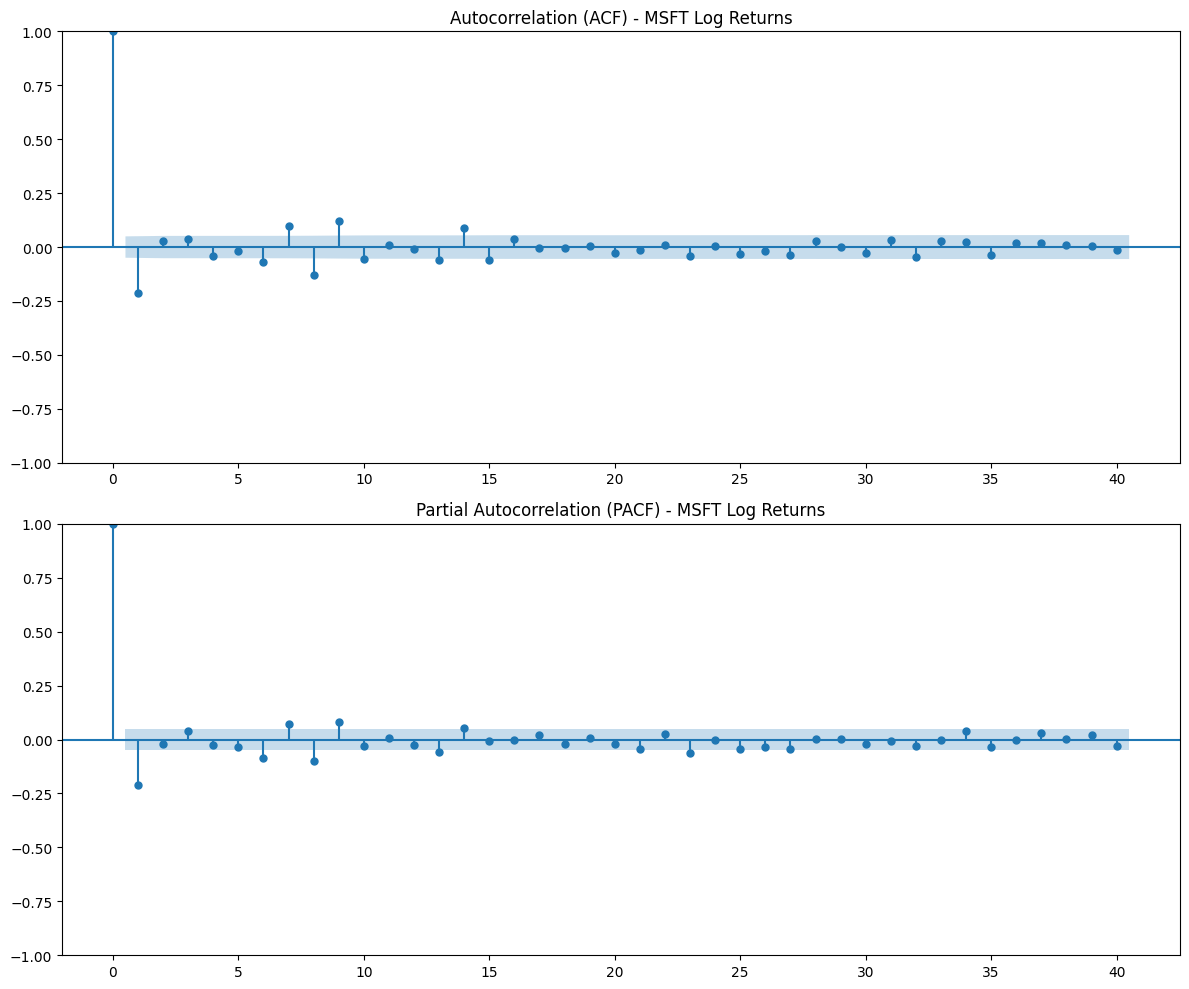

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set up a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot ACF (helps determine the 'q' or MA term)
# Lags=40 is a good default for daily stock data
plot_acf(stock.log_return, lags=40, ax=ax1)
ax1.set_title('Autocorrelation (ACF) - MSFT Log Returns')

# Plot PACF (helps determine the 'p' or AR term)
plot_pacf(stock.log_return, lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation (PACF) - MSFT Log Returns')

plt.tight_layout()
plt.show()

# MODEL

## TTS

In [16]:
tr = stock.iloc[:int(0.8*len(stock))]
val = stock.iloc[int(0.8*len(stock)):int(.85*len(stock))]
test = stock.iloc[int(.85*len(stock)):]

## ARIMA + GARCH + RF

In [20]:
forecast_days = 7

In [28]:
input_df = tr.copy()
output_df = val.head(forecast_days).copy() # Forces a strict 7-day window

# Initialize lists for the rolling process
history_returns = input_df['log_return'].tolist()
current_price = input_df['prices'].iloc[-1]

rolling_preds = []
upper_bounds = []
lower_bounds = []

In [29]:
for t in range(len(output_df)):
    try:
        # A. Fit ARIMA(2,0,2) to capture price momentum (Mean Model)
        # We use 'statespace' for better convergence on financial data
        arima_model = ARIMA(history_returns, order=(2, 0, 2))
        arima_result = arima_model.fit()
        mu_ret = arima_result.forecast(steps=1)[0]

        # B. Fit GARCH(1,1) on ARIMA residuals to capture volatility
        resid = arima_result.resid
        garch_model = arch_model(resid, vol='Garch', p=1, q=1, dist='normal', rescale=False)
        # rescale=False is used because returns are already scaled by 100
        garch_result = garch_model.fit(disp='off', show_warning=False)

        # C. Forecast Volatility (1-step sigma)
        g_forecast = garch_result.forecast(horizon=1)
        sigma = np.sqrt(g_forecast.variance.values[-1, 0])

        # D. Convert Predicted Returns back to Price Levels
        # Formula: P_{t+1} = P_t * exp(return / 100)
        pred_p = current_price * np.exp(mu_ret / 100)

        # E. Calculate 95% Confidence Interval (The Grey Band)
        # 1.96 standard deviations covers 95% of a normal distribution
        up_p = current_price * np.exp((mu_ret + 1.96 * sigma) / 100)
        lo_p = current_price * np.exp((mu_ret - 1.96 * sigma) / 100)

        # Store predictions
        rolling_preds.append(pred_p)
        upper_bounds.append(up_p)
        lower_bounds.append(lo_p)

        # F. UPDATE STEP: Ingest actual data for the next day's forecast
        # This prevents "horizontal line" drift by updating the model's memory
        actual_return = output_df['log_return'].iloc[t]
        current_price = output_df['prices'].iloc[t] # Use actual price to reset basis
        history_returns.append(actual_return)

        print(f"Day {t+1} Forecast: {pred_p:.2f} | Actual: {current_price:.2f}")

    except Exception as e:
        print(f"Solver error at Day {t+1}: {e}. Using persistence fallback.")
        rolling_preds.append(current_price)
        upper_bounds.append(current_price * 1.05)
        lower_bounds.append(current_price * 0.95)

Day 1 Forecast: 167.09 | Actual: 166.80
Day 2 Forecast: 167.15 | Actual: 166.50
Day 3 Forecast: 166.82 | Actual: 165.70
Day 4 Forecast: 165.79 | Actual: 166.72
Day 5 Forecast: 166.87 | Actual: 165.04
Day 6 Forecast: 165.35 | Actual: 162.28
Day 7 Forecast: 162.70 | Actual: 165.46


## Plotting


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(output_df['prices'], rolling_preds))
mape = mean_absolute_percentage_error(output_df['prices'], rolling_preds)

print(f"\n--- MODEL PERFORMANCE ---")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2%}") # Lower is better


--- MODEL PERFORMANCE ---
RMSE: $1.81
MAPE: 0.93%


In [40]:
import plotly.graph_objects as go

# 1. Prepare Historical Data (Last 30 days of training)
hist_slice = input_df.tail(30)

# 2. Add the "Bridge" point (last point of history) to the forecast arrays
# This ensures the red line and grey band touch the blue historical line
plot_idx = [hist_slice.index[-1]] + list(output_df.index)
plot_preds = [hist_slice['prices'].iloc[-1]] + rolling_preds
plot_upper = [hist_slice['prices'].iloc[-1]] + upper_bounds
plot_lower = [hist_slice['prices'].iloc[-1]] + lower_bounds

# 3. Calculate Error Metrics for the Popup
rmse = np.sqrt(mean_squared_error(output_df['prices'], rolling_preds))
mape = mean_absolute_percentage_error(output_df['prices'], rolling_preds)

In [48]:
fig = go.Figure()

# A. Plot Historical Training Data (Dashed Blue)
fig.add_trace(go.Scatter(
    x=hist_slice.index, y=hist_slice['prices'],
    mode='lines', name='Historical (30d)',
    line=dict(color='cyan', width=2)
))

# B. Plot Actual Prices for the 7-day period (Markers)
fig.add_trace(go.Scatter(
    x=output_df.index, y=output_df['prices'],
    mode='markers+lines', name='Actual (Val)',
    marker=dict(color='lime', size=8),
    line=dict(color='lime', width=1)
))

# C. Plot Rolling Forecast (Solid Red)
fig.add_trace(go.Scatter(
    x=plot_idx, y=plot_preds,
    mode='lines', name='7-Day Rolling Forecast',
    line=dict(color='red', width=2, dash='dash')
))

# D. Plot GARCH Confidence Interval (Shaded Grey)
fig.add_trace(go.Scatter(
    x=plot_idx + plot_idx[::-1], # x then x reversed
    y=plot_upper + plot_lower[::-1], # upper then lower reversed
    fill='toself',
    fillcolor='rgba(128, 128, 128, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name='95% GARCH Band'
))

# E. Add the "Error Popup" Annotation
fig.add_annotation(
    text=f"<b>Predictive Core Metrics</b><br>RMSE: ${rmse:.2f}<br>MAPE: {mape:.2%}",
    xref="paper", yref="paper",
    x=0.02, y=0.98, showarrow=False,
    align="left",
    bgcolor="rgba(128, 128, 128, 0.2)",
    bordercolor="black", borderwidth=1, borderpad=10
)

# F. Final Layout Polish
fig.update_layout(
    template='plotly_dark',
    title='MSFT Predictive Core: ARIMA-GARCH Rolling Dashboard',
    xaxis_title='Date',
    yaxis_title='Stock Price ($)',
    hovermode='x unified',
    legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99)
)

fig.show()